<a href="https://colab.research.google.com/github/yabramuvdi/imdb-wiki/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAAI Applied Machine Learning Pre-Doc Program** 
## ***Analysis Task***
### Yabra Muvdi
----


In [ ]:
import pandas as pd
import tarfile
import pickle
import numpy as np
import scipy.io as sio
import scipy.misc as spm
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
from IPython.display import Image, display

## **0. Download data**

We will start by retrieving the IMDB-WIKI dataset from the [official source](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/)

In [ ]:
# define the URLs and files names to download
base_url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/"
imdb_images = "imdb_crop.tar"
imdb_labels = "imdb_meta.tar"
wiki = "wiki.tar.gz"

In [ ]:
# get IMDB images
!wget "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar"
tar = tarfile.open(imdb_images)
tar.extractall()
tar.close()

--2020-11-13 16:53:37--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar       100%[===================>]   6.53G  9.75MB/s    in 11m 42s 

2020-11-13 17:05:19 (9.53 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]



In [ ]:
# get labels for IMDB dataset
!wget "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar"
tar = tarfile.open(imdb_labels)
tar.extractall()
tar.close()

--2020-11-13 17:07:41--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22937600 (22M) [application/x-tar]
Saving to: ‘imdb_meta.tar’

imdb_meta.tar       100%[===================>]  21.88M  7.25MB/s    in 3.0s    

2020-11-13 17:07:45 (7.25 MB/s) - ‘imdb_meta.tar’ saved [22937600/22937600]



In [ ]:
# get the WIKI dataset
!wget "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki.tar.gz"
tar = tarfile.open(wiki)
tar.extractall()
tar.close()

--2020-11-13 17:07:45--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3157487479 (2.9G) [application/x-gzip]
Saving to: ‘wiki.tar.gz’

wiki.tar.gz         100%[===================>]   2.94G  9.06MB/s    in 5m 22s  

2020-11-13 17:13:08 (9.35 MB/s) - ‘wiki.tar.gz’ saved [3157487479/3157487479]



## **1. Process data**

In order to start working with the dataset we need to transform the metada for each image from Matlab format to a format that we can use in Python. We can then construct DataFrames that will make the data analysis easier.

In [ ]:
def reformat_date(mat_date):
    """ Function to extract the year from the matlab raw date format.
        This information is necessary for calculating the age of the individual 
        in the image.

    Args:
        mat_date (str): raw date format

    Retrurns:
        year (int): extracted year
    """

    # Take account for difference in convention between matlab and python.
    year = datetime.date.fromordinal(np.max([mat_date - 366, 1])).year
    return year


def matlab_to_numpy(path_to_meta, matlab_file, path_to_images, dataset):
    """ Function to open a .mat file and reformat it into a dictionary of 
        numpy arrays.
    
    Args:
        path_to_meta (str): path to the directory with matlab file
        matlab_file (str): matlab file
        path_to_images (str): incomplete paths to images
        dataset (str): selection of which dataset to preprocess 'imdb' or 'wiki'

    Returns:
        data_dict: dictionary of numpy arrays
    """

    mat_struct = sio.loadmat(os.path.join(path_to_meta, matlab_file))
    data_set = [data[0] for data in mat_struct[dataset][0, 0]]

    keys = [
        'dob',
        'photo_taken',
        'full_path',
        'gender',
        'name',
        'face_location',
        'face_score',
        'second_face_score',
        'celeb_names',
        'celeb_id'
    ]

    # Creates path to full path to image from incomplete path.
    create_path = lambda path: os.path.join(path_to_images, path[0])

    data_dict = dict(zip(keys, np.asarray(data_set)))
    data_dict['dob'] = [reformat_date(dob) for dob in data_dict['dob']]
    data_dict['full_path'] = [create_path(path) for path in data_dict['full_path']]

    # Add 'age' key to the dictionary
    data_dict['age'] = data_dict['photo_taken'] - data_dict['dob']

    return data_dict

### **1.1 IMDB Dataset**

In [ ]:
# extract the metadata from the matlab file
imdb_dict = matlab_to_numpy("imdb", "imdb.mat", "imdb_crop", "imdb")

In [ ]:
# explore the number the dictionary
for key in imdb_dict.keys():
    print("Variable {} with {} elements".format(key, len(imdb_dict[key])))
    print("=============================\n")

Variable dob with 460723 elements

Variable photo_taken with 460723 elements

Variable full_path with 460723 elements

Variable gender with 460723 elements

Variable name with 460723 elements

Variable face_location with 460723 elements

Variable face_score with 460723 elements

Variable second_face_score with 460723 elements

Variable celeb_names with 20284 elements

Variable celeb_id with 460723 elements

Variable age with 460723 elements



In [ ]:
# delete the 'celeb_names' from the data given it is missing for several pictures
del imdb_dict["celeb_names"]

In [ ]:
# add dataset identifier
imdb_dict['dataset'] = ['imdb']*len(imdb_dict['age'])

In [ ]:
# transform into a pandas df
df_imdb = pd.DataFrame(imdb_dict)
df_imdb

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_id,age,dataset
0,1899,1968,imdb_crop/01/nm0000001_rm124825600_1899-5-10_1...,1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,6488,69,imdb
1,1899,1970,imdb_crop/01/nm0000001_rm3343756032_1899-5-10_...,1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,6488,71,imdb
2,1899,1968,imdb_crop/01/nm0000001_rm577153792_1899-5-10_1...,1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,6488,69,imdb
3,1899,1968,imdb_crop/01/nm0000001_rm946909184_1899-5-10_1...,1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,6488,69,imdb
4,1899,1968,imdb_crop/01/nm0000001_rm980463616_1899-5-10_1...,1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,6488,69,imdb
...,...,...,...,...,...,...,...,...,...,...,...
460718,1989,2011,imdb_crop/08/nm3994408_rm761245696_1989-12-29_...,0.0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN,8410,22,imdb
460719,1989,2011,imdb_crop/08/nm3994408_rm784182528_1989-12-29_...,0.0,[Jane Levy],"[[1, 1, 426, 640]]",-inf,NaN,8410,22,imdb
460720,1989,2011,imdb_crop/08/nm3994408_rm926592512_1989-12-29_...,0.0,[Jane Levy],"[[1, 1, 453, 640]]",-inf,NaN,8410,22,imdb
460721,1989,2011,imdb_crop/08/nm3994408_rm943369728_1989-12-29_...,0.0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN,8410,22,imdb


### **1.2 Wikipedia Dataset**

In [ ]:
# extract the metadata from the matlab file
wiki_dict = matlab_to_numpy("wiki", "wiki.mat", "wiki", "wiki")

In [ ]:
# explore the number the dictionary
for key in wiki_dict.keys():
    print("Variable {} with {} elements".format(key, len(wiki_dict[key])))
    print("=============================\n")

Variable dob with 62328 elements

Variable photo_taken with 62328 elements

Variable full_path with 62328 elements

Variable gender with 62328 elements

Variable name with 62328 elements

Variable face_location with 62328 elements

Variable face_score with 62328 elements

Variable second_face_score with 62328 elements

Variable age with 62328 elements



In [ ]:
# add dataset identifier
wiki_dict['dataset'] = ['wiki']*len(wiki_dict['age'])

In [ ]:
# transform into a pandas df
df_wiki = pd.DataFrame(wiki_dict)
df_wiki

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,age,dataset
0,1981,2009,wiki/17/10000217_1981-05-05_2009.jpg,1,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.30096,NaN,28,wiki
1,1925,1964,wiki/48/10000548_1925-04-04_1964.jpg,1,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.64564,1.94925,39,wiki
2,1948,2008,wiki/12/100012_1948-07-03_2008.jpg,1,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.32933,NaN,60,wiki
3,1930,1961,wiki/65/10001965_1930-05-23_1961.jpg,1,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,31,wiki
4,1971,2012,wiki/16/10002116_1971-05-31_2012.jpg,0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.40844,NaN,41,wiki
...,...,...,...,...,...,...,...,...,...,...
62323,1937,1963,wiki/49/9996949_1937-04-17_1963.jpg,1,[Guus Haak],"[[128.92773553879837, 128.92773553879837, 320....",4.02927,NaN,26,wiki
62324,1947,1970,wiki/32/9997032_1947-07-30_1970.jpg,1,[Nico Rijnders],"[[1, 1, 285, 440]]",-inf,NaN,23,wiki
62325,1972,2013,wiki/09/9998109_1972-12-27_2013.jpg,1,[Michael Wiesinger],"[[169.88839785556354, 74.31669471981023, 235.2...",3.4943,NaN,41,wiki
62326,1981,2011,wiki/00/9999400_1981-12-13_2011.jpg,1,[Johann Grugger],"[[1, 1, 1, 1]]",-inf,NaN,30,wiki


### **1.3. Final Dataset**

Now we can brinf the two datasets together and explore their content

In [ ]:
# join datasets
df = df_imdb.append(df_wiki)
df.reset_index(inplace=True)
df

,index,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_id,age,dataset
0,0,1899,1968,imdb_crop/01/nm0000001_rm124825600_1899-5-10_1...,1,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.45969,1.11897,6488.0,69,imdb
1,1,1899,1970,imdb_crop/01/nm0000001_rm3343756032_1899-5-10_...,1,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.5432,1.85201,6488.0,71,imdb
2,2,1899,1968,imdb_crop/01/nm0000001_rm577153792_1899-5-10_1...,1,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.45558,2.98566,6488.0,69,imdb
3,3,1899,1968,imdb_crop/01/nm0000001_rm946909184_1899-5-10_1...,1,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.87212,NaN,6488.0,69,imdb
4,4,1899,1968,imdb_crop/01/nm0000001_rm980463616_1899-5-10_1...,1,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.15877,NaN,6488.0,69,imdb
...,...,...,...,...,...,...,...,...,...,...,...,...
523046,62323,1937,1963,wiki/49/9996949_1937-04-17_1963.jpg,1,[Guus Haak],"[[128.92773553879837, 128.92773553879837, 320....",4.02927,NaN,NaN,26,wiki
523047,62324,1947,1970,wiki/32/9997032_1947-07-30_1970.jpg,1,[Nico Rijnders],"[[1, 1, 285, 440]]",-inf,NaN,NaN,23,wiki
523048,62325,1972,2013,wiki/09/9998109_1972-12-27_2013.jpg,1,[Michael Wiesinger],"[[169.88839785556354, 74.31669471981023, 235.2...",3.4943,NaN,NaN,41,wiki
523049,62326,1981,2011,wiki/00/9999400_1981-12-13_2011.jpg,1,[Johann Grugger],"[[1, 1, 1, 1]]",-inf,NaN,NaN,30,wiki


Age: 18
Gender: 1.0
Name: ['David Henrie']


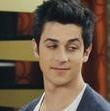



Age: 81
Gender: 1.0
Name: ['Buck Henry']


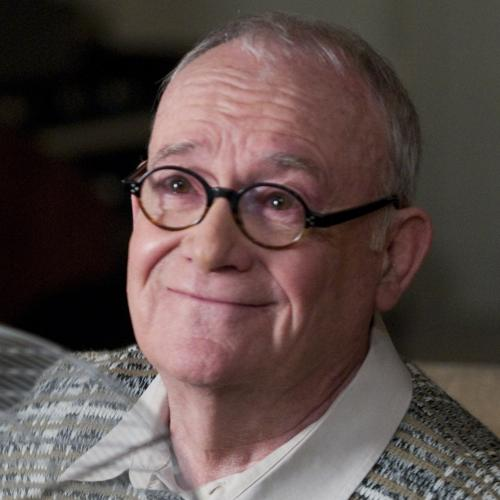



Age: 30
Gender: 0.0
Name: ['Sarah Polley']


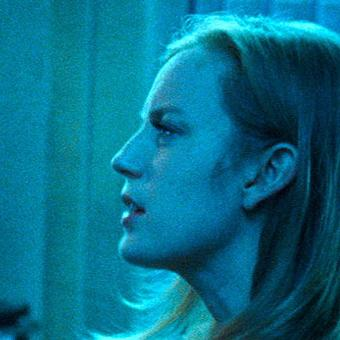



Age: 50
Gender: 1.0
Name: ['Billy Bob Thornton']


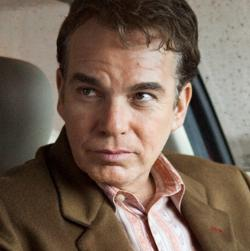



Age: 18
Gender: 1.0
Name: ['Michael van der Mark']


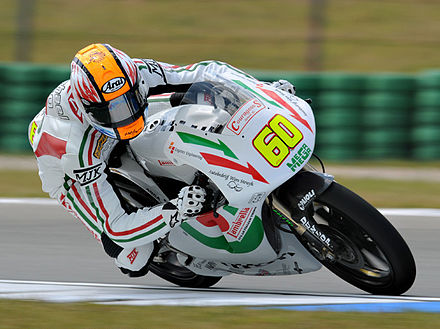



Age: 37
Gender: 1.0
Name: ['Henry Ian Cusick']


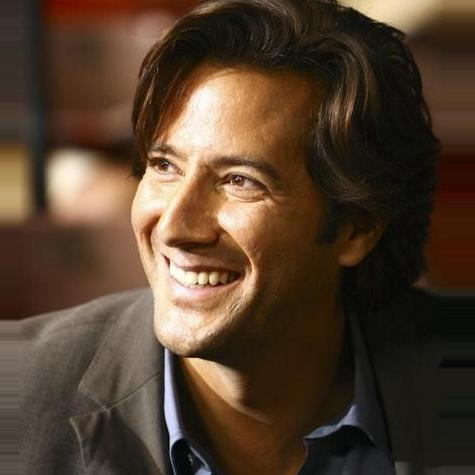



Age: 51
Gender: 1.0
Name: ['Joe Roth']


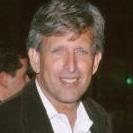



Age: 25
Gender: 0.0
Name: ['Minka Kelly']


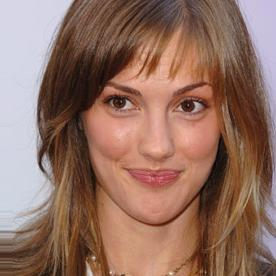



Age: 59
Gender: 0.0
Name: ['Helena Kennedy, Baroness Kennedy of The Shaws']


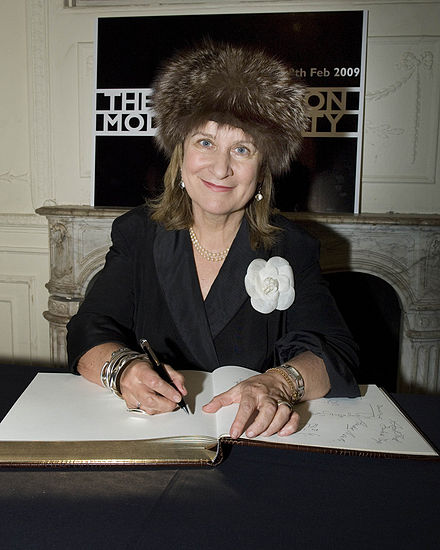



Age: 45
Gender: 0.0
Name: ['Amy Landecker']


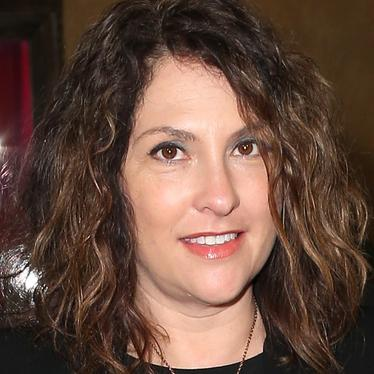

In [ ]:
# explore a number of random pictures with their metadata
n = 10
for i in np.random.randint(0, len(df), n):
    print("Age: " + str(df.loc[i, 'age']))
    print("Gender: " + str(df.loc[i, 'gender']))
    print("Name: " + str(df.loc[i, 'name']))
    display(Image(filename=df.loc[i, 'full_path']))
    print("===================================\n\n")


Interestingly, just from randomly picking some of the images of our dataset, we start gathering important information.

* *Images have very different formats:* Some are much larger than others, some are colored, some are black and white.
* *The images are noisy:* some pictures contained multiple faces, some others seem to contain an incorrect age.

## **2. Age distribution**

In [ ]:
# get summary statistics for the age metadata
df["age"] = df.age.apply(lambda x: float(x))
print(df.age.describe())

count    523051.000000
mean         37.405341
std          34.327385
min         -74.000000
25%          27.000000
50%          35.000000
75%          45.000000
max        2014.000000
Name: age, dtype: float64


There are clearly some invalid ages in our dataset:
* There are negative ages
* There are ages larger than [the oldes person who has ever lived](https://www.guinnessworldrecords.com/news/2020/5/worlds-oldest-man-bob-weighton-dies-aged-112#:~:text=The%20oldest%20person%20ever%20to,Kane%20Tanaka%20(Japan%2C%20b.)

In [ ]:
# remove invalid ages (negative or greater than 122)
df = df[(df["age"] > 0) & (df["age"] < 122)]

In [ ]:
# summary statistics after cleaning
print(df.age.describe())

count    520703.000000
mean         36.985660
std          13.659144
min           1.000000
25%          27.000000
50%          35.000000
75%          45.000000
max         121.000000
Name: age, dtype: float64


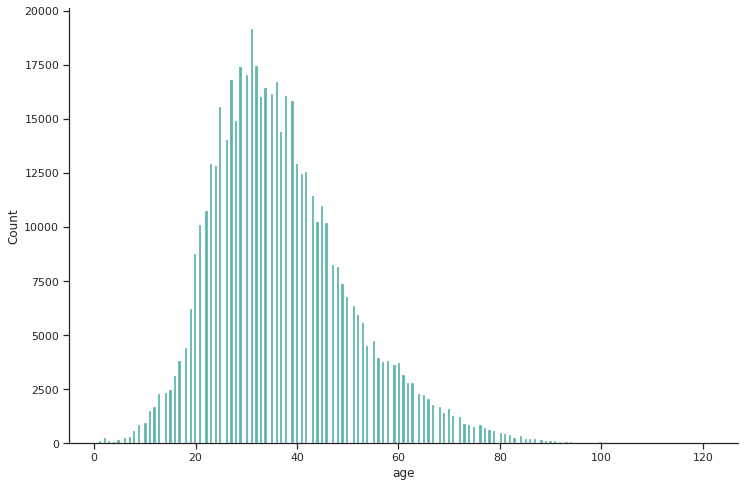

In [ ]:
# plot age distribution
sns.set_theme(style="ticks")
plt.figure(figsize=(12, 8))
sns.histplot(df, x="age", color="#2a9d8f")
sns.despine()
plt.savefig("histogram_age_count.jpeg")
plt.show()

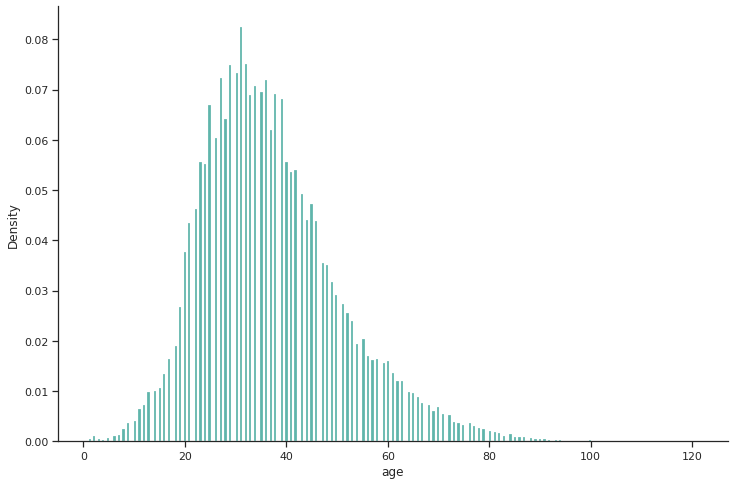

In [ ]:
# plot age distribution
plt.figure(figsize=(12, 8))
sns.histplot(df, x="age", stat="density", color="#2a9d8f")
sns.despine()
plt.savefig("histogram_age_density.jpeg")
plt.show()

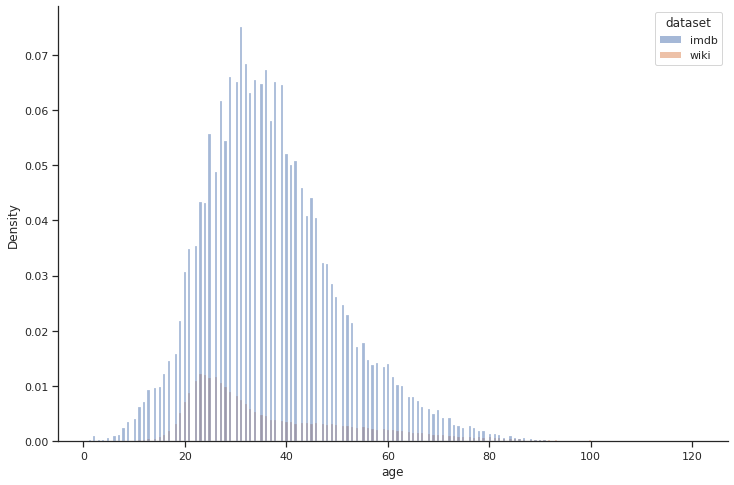

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(df, x="age", hue='dataset', stat="density")
sns.despine()
plt.show()

### **2.1. Size of the bucket “15 to 25 years old”**

In [ ]:
bucket = df[(df["age"] >= 15) & (df["age"] <= 25)]
bucket.age.describe()

count    90871.000000
mean        21.630399
std          2.756492
min         15.000000
25%         20.000000
50%         22.000000
75%         24.000000
max         25.000000
Name: age, dtype: float64

In [ ]:
print(len(bucket)/len(df))

0.1745159908815582


### **2.2. Population of "30 year old males"**

In [ ]:
bucket2 = df[(df["age"] == 30) & (df["gender"] == 1)]
print(bucket2.age.describe())
print("=========================")
print(bucket2.gender.describe())

count    8565.0
mean       30.0
std         0.0
min        30.0
25%        30.0
50%        30.0
75%        30.0
max        30.0
Name: age, dtype: float64
count     8565.0
unique       1.0
top          1.0
freq      8565.0
Name: gender, dtype: float64


In [ ]:
print(len(bucket2)/len(df))

0.016448916176784078


### **Gender composition**

In [ ]:
df.gender.value_counts(normalize=True)

1.0    0.605061
0.0    0.394939
Name: gender, dtype: float64